# Sustainable Portfolio Selection -- Markowitz goes ESG
Ecological, social and governance measures are gaining importance in the realm of financial services. On the one hand, investors' principles and their recognition of non-financial risks connected to exploitative business lead to a growing green capital market. On the other hand, allocating capital for ecological and social companies promotes sustainable development as it is aimed for e.g. in UN's 17 SDGs (sustainable development goals). As a reaction to climate change and human rights movements ESG measures will become legally relevant in the forseeable future. 

This article shows how ESG-Data can be used in portfolio decisions. 
The present text is standalone and targets readers who are interested, but not neccessarily familiar with portfolio optimization.


### Overview

We follow roughly the steps in [Jason Ramchandani's Portfolio Optimisation](https://developers.refinitiv.com/en/article-catalog/article/portfolio-optimization-modern-portfolio-theory) and build up an effective frontier from Markowitz' classical portfolio selection theory. But in difference to the classical risk-return-approach, we aim at a low risk combined with high ESG score. 

For details on ESG measures we refer to Gurpreet Bal's article ["How to integrate ESG data into investment decisions"](https://developers.refinitiv.com/en/article-catalog/article/how-integrate-esg-data-investment-decisions). We enhance his approach of selecting an ESG subset of a given index by requiring a lower bound on the TR ESG Score.    


### Technical prerequisites

 * Refinitiv Eikon / Workspace with access to Eikon Data APIs (Free Trial Available)
 * Python 3.x
 * Required Python Packages: eikon, pandas 0.17.0 or higher, numpy, scipy, matplotlib

### Portfolio selection at a glance
In portfolio selection, a set of shares is given, e.g. an index, for example all shares listed in DAX. 
From this so-called **universe**, a combination of shares is selected into a portfolio. The selection follows some conditions and optimization goals. 
A classical **condition** on portfolios is an upper bound on the weight of a single share preventing high risks due to one very strong component. 
Classical **goals** are for instance a maximal expected return of the portfolio, a minimum mean variance, or low risk measures. 
In this tutorial, we will include a high ESG-Score into the optimization goal.

In [1]:
import eikon as ek

import pandas

import numpy

import matplotlib.pyplot as plt

import scipy.optimize as sco 

import os

ek.set_app_key('YOUR API KEY HERE')

## Getting instruments and data
Our portfolio will be built from a universe (or a pre-selection) of shares. We will work based on ETF iShares Core MSCI World UCITS ETF USD which is based on the MSCI World index.

### Reading a universe from Eikon
We use Eikon to get the constituents of the index. For simplicity we will reduce the list of entries here to 100. 

In [2]:
N=100
constituents, err = ek.get_data(['IWDA.L'], ['TR.ETPConstituentRIC', 'TR.ETPConstituentName'])
constituents.rename(columns={'Constituent RIC': 'ric', 'Constituent Name': 'name'}, inplace=True)
constituents = constituents[['ric','name']][0:N]
print(constituents)

        ric                                  name
0   FITB.OQ               FIFTH THIRD BANCORP ORD
1   HOLX.OQ                           HOLOGIC ORD
2    8630.T                   SOMPO HLDGS INC ORD
3   CTSH.OQ  COGNIZANT TECHNOLOGY SOLUTN CL A ORD
4    6965.T               HAMAMATSU PHOTONICS ORD
..      ...                                   ...
95   CBOE.Z           CBOE GLOBAL MARKETS INC ORD
96   8031.T                            MITSUI ORD
97  OREP.PA                          L OREAL S.A.
98   BDEV.L                      BARRATT DEVLPMNT
99  DAST.PA                 DASSAULT SYSTEMES ORD

[100 rows x 2 columns]


### Reading instruments time series price data
We get the time series of our chosen instruments for one year. We need to remove the NA data in order to prevent problems with calculating the covariance matrix.

In [3]:
start='2020-01-01'
end='2020-12-31'
instruments = constituents['ric'].astype(str).values.tolist()
ts =pandas.DataFrame()
for r in instruments:
    try:
        ts1 = ek.get_timeseries(r,'CLOSE',start_date=start,end_date=end,interval='daily')
        ts1.rename(columns = {'CLOSE' : r}, inplace=True)
        ts =pandas.concat([ts, ts1], axis=1)
    except:
        continue
ts = ts.dropna()

In [4]:
print(ts)

            FITB.OQ  HOLX.OQ  8630.T  CTSH.OQ  6965.T       AVV.L   WCN.N  \
Date                                                                        
2020-01-07   29.850   52.490  4280.0    60.32    4555  3789.54556   92.58   
2020-01-08   29.920   52.290  4188.0    60.73    4490  3815.21564   93.27   
2020-01-09   30.250   53.275  4228.0    61.11    4545  3828.05068   93.75   
2020-01-10   29.760   53.170  4239.0    60.64    4530  3805.58936   93.82   
2020-01-14   29.740   53.530  4213.0    61.37    4575  3905.06092   95.13   
...             ...      ...     ...      ...     ...         ...     ...   
2020-12-21   27.165   75.230  4038.0    80.47    6030  3199.00000  101.64   
2020-12-22   26.930   74.670  4034.0    81.02    5880  3213.00000  102.72   
2020-12-23   27.730   75.060  4068.0    80.99    5920  3209.00000  101.23   
2020-12-29   27.280   71.740  4186.0    80.50    6060  3281.00000  101.48   
2020-12-30   27.280   71.750  4173.0    81.07    5900  3225.00000  101.84   

### Reading ESG-data from Eikon
Refinitiv provides a large bunch of data connected to ESG-evaluation of companies. In this exemplary portfolio selection, we use the TR.TRESGScore which ranges from 0 to 100.

In [5]:
df_esg, err = ek.get_data(instruments, ['TR.TRESGScore','TR.BusinessSummary'])
df_esg = df_esg.rename(columns={'Instrument':'ric', 'ESG Score':'esg'}).set_index('ric')
df_esg = pandas.concat([constituents.set_index('ric'), df_esg], join='inner', axis=1)

In [6]:
df_esg

,name,esg,Business Description
ric,,,
FITB.OQ,FIFTH THIRD BANCORP ORD,69.891816,Fifth Third Bancorp is a bank holding company ...
HOLX.OQ,HOLOGIC ORD,73.698711,"Hologic, Inc. is a developer, manufacturer and..."
8630.T,SOMPO HLDGS INC ORD,71.080134,"Sompo Holdings, Inc. is a Japan-based company ..."
CTSH.OQ,COGNIZANT TECHNOLOGY SOLUTN CL A ORD,58.391002,Cognizant Technology Solutions Corporation is ...
6965.T,HAMAMATSU PHOTONICS ORD,60.111937,HAMAMATSU PHOTONICS K.K. is a Japan-based comp...
...,...,...,...
CBOE.Z,CBOE GLOBAL MARKETS INC ORD,46.769310,"Cboe Global Markets, Inc. is a holding company..."
8031.T,MITSUI ORD,71.280614,"Mitsui & Co., Ltd. is a general trading compan..."
OREP.PA,L OREAL S.A.,79.008395,L'Oreal SA is a France-based cosmetics company...


## Unconstrained minimum volatility portfolio (MVP)
As a first step, we calculate the classic minimum volatility portfolio.

### Calculate past returns and covariance matrix
We calculate the past returns using pandas. We need to remove the NA numbers, that will be occuring in the first row -and possibly elsewhere.

In [7]:
returns = ts.pct_change().replace(numpy.inf, numpy.nan).dropna()
covMatrix = returns.cov()

### Define risk measure
Using the covariance matrix, we define a risk measure based on volatility:

In [8]:
def risk_measure(covMatrix, weights):
    return numpy.dot(weights, numpy.dot(covMatrix, weights))

First, we set the boundary conditions for the single weights that should range between 0 and 1.

In [9]:
bounds = len(instruments) * [(0, 1)]

Second, we set the condition that the weights should add up to 1.

In [10]:
constraints = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}

The minimum volatility portfolio (MVP) portfolio is computed by scipy's optimize function, which returns a result 'res' that includes the portfolio weights 'res['x']' and the minimized risk measure 'res['fun']'. 
We evaluate the number of instruments in the portfolio, the minimum and maximum weights, the MVP's (historical) annual return, it's volatility, and also the ESG score.

In [11]:
mvp = sco.minimize(lambda x: risk_measure(covMatrix, x),  # function to be minized
                   len(instruments) * [1 / len(instruments)],  # initial guess
                   bounds=bounds,  # boundary conditions
                   constraints =constraints,  # equality constraints
                   )
mvp_weights = list(mvp['x'])
mvp_esg = numpy.dot(mvp_weights, df_esg['esg'])
mvp_risk = mvp['fun']
print('\nMVP in a universe with {N} instruments\nNumber of selected instruments: {n}\nMinimum weight: {minw}\nMaximum weight: {maxw}\nHistorical risk measure: {risk}\nHistorical return p.a.: {r}\nESG score: {esg}'.format(N=N,n=numpy.sum(mvp['x']>0),minw=numpy.min(mvp['x'][numpy.nonzero(mvp['x'])]),maxw=numpy.max(mvp['x']),risk=mvp_risk,r=numpy.dot(mvp_weights,returns.sum()),esg=mvp_esg))


MVP in a universe with 100 instruments
Number of selected instruments: 65
Minimum weight: 2.44826270139076e-20
Maximum weight: 0.06396593250127255
Historical risk measure: 0.0001294899285868813
Historical return p.a.: 0.07872510570868128
ESG score: 55.31860881168306


### Results
We use a pandas DataFrame to assign the weights to the instruments, sort them by size and remove the very small ones for the plot (note that in order to use the sort_values function your pandas version needs to be higher than 0.17.0).

In [12]:
df_weights =pandas.DataFrame(data=mvp_weights, index=instruments)
df_weights =df_weights.sort_values(by=[0], ascending=False)
df_weights =df_weights[df_weights > 1e-4].dropna()
df_weights =df_weights.T

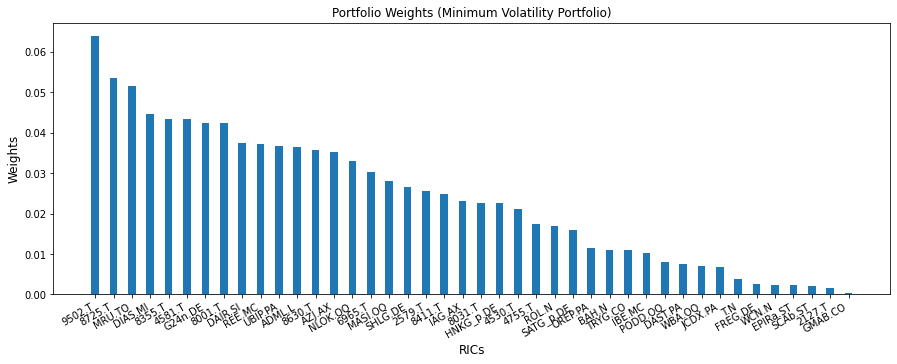

In [13]:
#plotting the weights 
plt.figure(figsize=(15, 5))
ypos = numpy.linspace(0, 100, num=len(df_weights.iloc[0,:]))
plt.bar(ypos, df_weights.values[0], width =1)
plt.xticks(ypos, df_weights.columns, rotation =30, ha ='right')
plt.xlabel('RICs', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Portfolio Weights (Minimum Volatility Portfolio)', fontsize=12)
plt.show()

## MVP for prescribed ESG score
We are now interested in selecting a portfolio with a higher ESG score than the MVP. This additional restriction is implemented via a second constraint in scipy's optimize. Note that the prescribed ESG score should be higher than the MVP's ESG -- we are the good guys, and want more ecological, social and governance value! On the other hand, the maximum ESG can be achieved by simply investing all the money into the highest rated instrument -but that would be too much of a risk, we want more diversity. This yields an upper bound on a meaningful setting for the prescribed ESG. 

In [14]:
prescribed_esg = 80

esg_constraint = {'type': 'eq', 'fun': lambda weights: numpy.dot(weights, df_esg['esg']) - prescribed_esg}
esgmvp = sco.minimize(lambda x: risk_measure(covMatrix, x),  # function to be minized
                   len(instruments) * [1 / len(instruments)],  # initial guess
                   bounds=bounds,  # boundary conditions
                   constraints =[constraints, esg_constraint],  # equality constraints
                   )
esgmvp_weights = list(esgmvp['x'])
esgmvp_esg = numpy.dot(esgmvp_weights, df_esg['esg'])
esgmvp_risk = esgmvp['fun']

print('\nMVP with prescribes ESG = {pe} in a universe with {N} instruments\nNumber of selected instruments: {n}\nMinimum weight: {minw}\nMaximum weight: {maxw}\nHistorical risk measure: {risk}\nHistorical return p.a.: {r}\nESG score: {esg}'.format(N=N,n=numpy.sum(esgmvp['x']>0),minw=numpy.min(esgmvp['x'][numpy.nonzero(esgmvp['x'])]),maxw=numpy.max(esgmvp['x']),risk=esgmvp_risk,r=numpy.dot(esgmvp_weights,returns.sum()),esg=esgmvp_esg,pe=prescribed_esg))


MVP with prescribes ESG = 80 in a universe with 100 instruments
Number of selected instruments: 66
Minimum weight: 2.0241858872983442e-20
Maximum weight: 0.09328007383074229
Historical risk measure: 0.00024141858003072668
Historical return p.a.: 0.15745991254900046
ESG score: 80.00000000021717


### Results
We use a pandas DataFrame to assign the weights to the instruments, sort them by size and delete the very small ones:

In [15]:
df_weights =pandas.DataFrame(data=esgmvp_weights, index=instruments)
df_weights =df_weights.sort_values(by=[0], ascending=False)
df_weights =df_weights[df_weights > 1e-4].dropna()
df_weights =df_weights.T

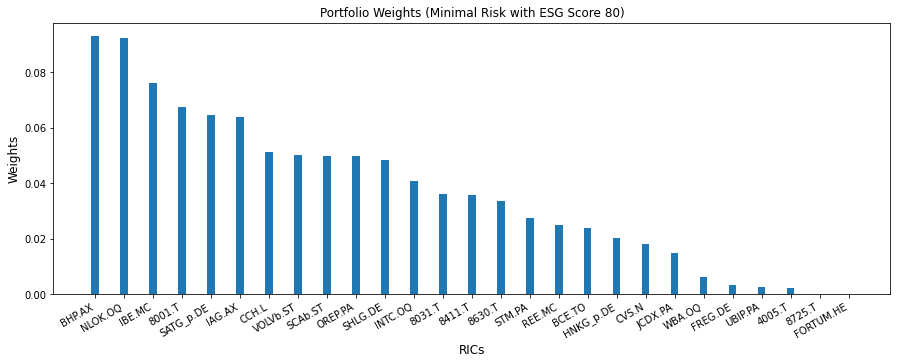

In [16]:
#plotting the weights
plt.figure(figsize=(15, 5))
ypos = numpy.linspace(0, 100, num=len(df_weights.iloc[0,:]))
plt.bar(ypos, df_weights.values[0], width =1)
plt.xticks(ypos, df_weights.columns, rotation =30, ha ='right')
plt.xlabel('RICs', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Portfolio Weights (Minimal Risk with ESG Score 80)', fontsize=12)
plt.show()

The risk measure of the resulting portfolio is increased compared to the MVP, because we optimize over a more restricted set -- namely, only those portfolios providing the prescribed ESG score instead of all possible portfolios. But nothing is said about the historical return: In this example, it is increased by a factor of about 2 compared to the MVP. Demanding more value for the climate, the environment and for humans can thus lead to higher return. 

## ESG-efficient frontier
Portfolios can be evaluated with respect to return and volatility, and plotted as dots into a respective coordinate system. In the classical context of H. Markowitz, the **efficient frontier** is a line that consists of all those portfolio-dots, which are efficient in the following sense: There is no other portfolio which has the same return at a lower risk. 

We adjust this idea to the ESG context by replacing Markowitz's return with the ESG score. From a mathematical viewpoint, both measures are very similar: The return/ESG of a portfolio is computed as a scalar product of a vector with return/ESG scores of the instruments with the weights vector. 

To build up the **ESG-efficient frontier**, we calculate several optimal portfolios with different prescribed ESG values. The prescribed ESG values will be in the range between the MVP's ESG, and the maximum ESG of all instruments in the underlying universe. We save the resulting portfolio weights, their ESG value and their risk measure in our results dictionary. 

In [17]:
max_esg=numpy.floor(max(df_esg['esg'].values.tolist())) #max esg value to be achieved dependent on the universe
min_esg=mvp_esg #min esg value which is interesting for portfolio selection

results = {'esg_val':[],'weights':[],'risk':[],'return':[]}
for rho in numpy.linspace(min_esg,max_esg,num=25):
    constraints2 = {'type': 'eq', 'fun': lambda weights: numpy.dot(weights, df_esg['esg']) - rho}
    res = sco.minimize(lambda x: risk_measure(covMatrix, x),  # function to be minized
                   len(instruments) * [1 / len(instruments)],  # initial guess
                   bounds=bounds,  # boundary conditions
                   constraints =[constraints, constraints2],  # equality constraints
                       )
    weights = list(res['x'])
    esg_val= numpy.dot(weights, df_esg['esg'])
    results['esg_val'].append(esg_val)
    results['weights'].append(weights)
    results['risk'].append(res['fun'])
    results['return'].append(numpy.dot(weights,returns.sum()))


### Results
Plotting our result:

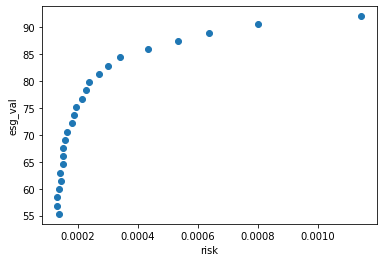

In [18]:
plt.plot(results['risk'],results['esg_val'], 'o')
plt.xlabel('risk')
plt.ylabel('esg_val')
plt.show()

### Remark on the trade-off between risk and ESG rating in this model
The fact that a higher ESG score comes with higher risks is intrinsic to this model, but it does not fully recover reality (that's always the problem with mathematical models . . . ). One just minimizes over a subset, and the minimum will thus increase.
As a remedy, one can enlarge or change the universe. In this way, almost any combination of ESG score, risk measure and (expected) return can be achieved.

A happier fact (also kind of model-intrinsic) is that higher ESG scores come with higher returns within the ESG-efficient portfolios:

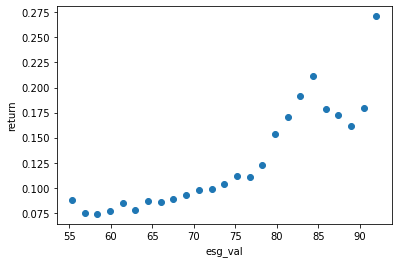

In [19]:
plt.plot(results['esg_val'],results['return'],'o')
plt.xlabel('esg_val')
plt.ylabel('return')
plt.show()

## Outlook
This tutorial focuses on employing ESG-data in portfolio selection. 
For this purpose, we chose simple models for returns and risks. One can enhance both measures, e.g. by forecasting methods, weighted or non-smooth risk measures, and more. 
Furthermore, we did not consider the expected return in our optimization and utilized only one out of a bunch of ESG data that is available via Eikon. One can include more constraints or add terms to the objective functional of the optimization problem.  

For more details on portfolio optimization see [Portfolio Selection by Dr. Yves J. Hilpisch](https://github.com/yhilpisch/eikondataapi/blob/master/notebooks/06_tpq_eikon_portfolio_selection.ipynb) and [Jason Ramchandani's Portfolio Optimisation Part II](https://developers.refinitiv.com/en/article-catalog/article/portfolio-optimisation-ii).

For more information about the authors, check out [https://goldmarie-finanzen.de](https://goldmarie-finanzen.de)!